In [ ]:
!pip install Pillow --upgrade -q

     |████████████████████████████████| 3.2 MB 5.3 MB/s 


Restart environment after ugrading Pillow (*Runtime → Restart runtime*)

In [ ]:
!unzip -q passport-fonts

In [ ]:
import random
from pathlib import Path

import numpy as np
from scipy import stats

import cv2
import imutils
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image

from tqdm import tqdm

In [ ]:
# 31 chars "АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯ", except "Ё", "Ъ"
CHAR_FREQ = [0.07998, 0.01592, 0.04533, 0.01687, 0.02977, 0.08483, 0.0094, 0.01641, 0.07367, 0.01208, 0.03486, 0.04343, 0.03203, 0.067, 0.10983, 0.02804, 0.04746, 0.05473, 0.06318, 0.02615, 0.00267, 0.00966, 0.00486, 0.0145, 0.00718, 0.00361, 0.01898, 0.01735, 0.00331, 0.00639, 0.02001]

In [ ]:
#@title { form-width: "1px" }
#@markdown ```python
#@markdown def show(img, size=4, bgr=True)
#@markdown def translate(tx=0, ty=0)
#@markdown def scale(sx=1, sy=1)
#@markdown def rotate(degrees, center=(0, 0))
#@markdown def get_warp_matrix(icx=0, icy=0, ocx=0, ocy=0, scale_x=1, scale_y=1, rotate_deg=0)
#@markdown def transform_affine(image, shift_x=0, shift_y=0, scale_x=1, scale_y=1,
#@markdown     rotate_deg=0, rotation_center=(0.5, 0.5), output_size=(None, None), fill_value=0)
#@markdown def make_noise(shape, low=0.0, high=1.0, zoom=1.0, blur=(1, 1), seed=None)
#@markdown def get_blank_image(w, h, ch=None, fill=0, uint8=True)
#@markdown def get_image_text_bbox(text, font, font_size)
#@markdown def draw_text(pil_img, text, x=0, y=0, font_size=12, font=None, color=0,
#@markdown     spacing=4, anchor='la', stroke=0, stroke_fill=0, inplace=False)
#@markdown ```
def show(img, size=4, bgr=True):
    plt.figure(figsize=(size, size))
    if len(img.shape) == 3:
        plt.imshow(img[..., ::-1] if bgr else img)
    else:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
    plt.box()
    print(img.shape)
    
    
def translate(tx=0, ty=0):
    T = np.eye(3)
    T[0:2, 2] = [tx, ty]
    return T

def scale(sx=1, sy=1):
    T = np.diag([sx, sy, 1])
    return T

def rotate(degrees, center=(0, 0)):
    T = np.eye(3)
    # just involves some sin() and cos()
    T[0:2] = cv2.getRotationMatrix2D(center=center, angle=-degrees, scale=1.0)
    return T


def get_warp_matrix(icx=0, icy=0,
                    ocx=0, ocy=0,
                    scale_x=1, scale_y=1,
                    rotate_deg=0):
    """ Point (icx, icy) will be used as rotation center
        and translated to (ocx, ocy) in the output image.
    """
    # Translations are read from right to left
    H = translate(+ocx, +ocy) @ rotate(rotate_deg) @ scale(scale_x, scale_y) @ translate(-icx, -icy)
    return H[:2]


# Based on https://stackoverflow.com/a/72928370 by @Christoph Rackwitz
def transform_affine(image,
                     shift_x=0, shift_y=0,
                     scale_x=1, scale_y=1,
                     rotate_deg=0, rotation_center=(0.5, 0.5),
                     output_size=(None, None), fill_value=0):
    """
    Flip image with scale = -1.
    
    No transformation applied:
    
    >>> image2 = transform_affine(image, 0, 0, 1, 1, 0, (.5, .5), output_size=(None, None))
    >>> (image == image2).all()
    True
    """
    src_h, src_w = image.shape[:2]
    icx, icy = src_w * rotation_center[0], src_h * rotation_center[1]
    ocx, ocy = icx + shift_x, icy + shift_y
    M = get_warp_matrix(icx, icy, ocx, ocy, scale_x, scale_y, rotate_deg)
    
    interp_mode = cv2.INTER_LINEAR if scale_x > 1 and scale_y > 1 else cv2.INTER_AREA
    dest_w = src_w if output_size[0] is None else output_size[0]
    dest_h = src_h if output_size[1] is None else output_size[1]
    return cv2.warpAffine(image, M, (dest_w, dest_h), flags=interp_mode, borderValue=fill_value)


def make_noise(shape, low=0.0, high=1.0, zoom=1.0, blur=(1, 1), seed=None):
    assert 0.0 <= low <= high <= 1.0
    assert 1.0 <= zoom
    h, w = shape
    s = high - low
    img = (np.random.RandomState(seed).rand(h, w) * s) + low
    if blur != (1, 1):
        img = cv2.GaussianBlur(img, blur, 0)
    if zoom > 1:
        img = imutils.resize(img[: round(h / zoom), : round(w / zoom)], width=w)
    return (img * 255).round().astype(np.uint8)


def get_blank_image(w, h, ch=None, fill=0, uint8=True):
    shape = (h, w, ch) if ch else (h, w)
    dtype = np.uint8 if uint8 else np.float32
    return np.full(shape, fill, dtype=dtype)


def get_image_text_bbox(text, font, font_size):
    return ImageFont.truetype(font, font_size).getbbox(text)


def draw_text(pil_img, text, x=0, y=0, font_size=12, font=None, color=0,
              spacing=4, anchor='la', stroke=0, stroke_fill=0, inplace=False):
    """
    anchor: str
        Two-character string:
        1. First char: {l=left, m=middle, r=right}
        2. Second char: {a=ascender, t=top, m=middle, s=baseline, b=bottom, d=descender}
        More info: https://pillow.readthedocs.io/en/stable/handbook/text-anchors.html
    """
    if not inplace:
        pil_img = pil_img.copy()
    if font is None:
        image_font = ImageFont.load_default()
    else:
        image_font = ImageFont.truetype(font, font_size)
    draw = ImageDraw.Draw(pil_img)
    draw.text((x, y), text, font=image_font, spacing=spacing, fill=color, anchor=anchor,
              stroke_width=stroke, stroke_fill=stroke_fill)
    return pil_img

 66%|██████▌   | 132073/200000 [19:24<09:59, 113.39it/s]

(80, 160)


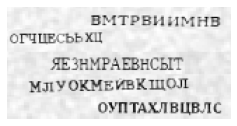

In [ ]:
#@title { form-width: "1px" }
#@markdown ```python
#@markdown class GeneratorConfig()
#@markdown class DatasetGenerator(config)
#@markdown ```
class GeneratorConfig:
    
    ## Image settings
    IMAGE_WIDTH = 160
    IMAGE_HEIGHT = 16
    
    ## Noise settings
    ADD_NOISE_TEXT = True
    ADD_NOISE_BG = True
    
    ## Font settings
    FONTS_DIR = 'passport-fonts'
    FONT_SIZE_MIN = 12
    FONT_SIZE_MAX = 12
    
    ## Text setting
    CYRILLIC_CHARS = 'АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯ'
    MIN_CHARS = 6
    MAX_CHARS = 13
    RANDOM_ANGLE_DEGREES_MAX = 2
    RANDOM_BLUR = False


class DatasetGenerator:
    
    def __init__(self, config):
        self.cfg = config
        self.rng = random.Random()
        self.fonts = list(map(str, Path(self.cfg.FONTS_DIR).glob('*.tt[fc]')))
        if len(self.fonts) < 1:
            raise ValueError(f'No font files found in "{self.cfg.FONTS_DIR}"')
        
        # Cache transformations
        w = self.cfg.IMAGE_WIDTH
        h = self.cfg.IMAGE_HEIGHT
        self.cx, self.cy = round(w / 2), round(h / 2)
        self.T_1 = translate(-self.cx, -self.cy)
        self.T_4 = translate(self.cx, self.cy)
        
        # Cache random values
        self.noise = make_noise((100, 1000), 0.0, 0.2, zoom=2, blur=(3, 3))
        self.rotation_mat = np.empty((1000, 3, 3), dtype=np.float32)
        random_angle_deg = self.cfg.RANDOM_ANGLE_DEGREES_MAX
        for i, degrees in enumerate(np.linspace(-random_angle_deg, random_angle_deg, 1000)):
            self.rotation_mat[i] = rotate(degrees)
        
    
    def random_cyr_string_v1(self, seed=None):
        chars = np.array(list(self.cfg.CYRILLIC_CHARS))
        string_len = np.random.RandomState(seed).randint(
            self.cfg.MIN_CHARS,
            self.cfg.MAX_CHARS + 1)
        index = np.random.RandomState(seed).randint(len(chars), size=string_len)
        return ''.join(chars[index])
        

    def random_cyr_string(self, seed=None):
        lens_list = np.arange(self.cfg.MIN_CHARS, self.cfg.MAX_CHARS + 1)
        lens_p = np.geomspace(0.3, 1, len(lens_list))
        # P = [0.3 , 0.34, 0.39, 0.45, 0.51, 0.59, 0.67, 0.77, 0.87, 1.  ]
        string_len = self.rng.choices(lens_list, weights=lens_p)[0]

        chars = random.choices(self.cfg.CYRILLIC_CHARS, weights=CHAR_FREQ, k=string_len)
        return ''.join(chars)

        
    def random_font_size(self):
        return self.rng.randint(self.cfg.FONT_SIZE_MIN, self.cfg.FONT_SIZE_MAX)
    
    
    def random_noise(self):
        h, w = self.noise.shape
        x = self.rng.randrange(w - self.cfg.IMAGE_WIDTH)
        y = self.rng.randrange(h - self.cfg.IMAGE_HEIGHT)
        return self.noise[y : y + self.cfg.IMAGE_HEIGHT, x : x + self.cfg.IMAGE_WIDTH]
    
    
    def random_font(self):
        return self.rng.choice(self.fonts)
    
    
    def get_blank(self):
        return get_blank_image(self.cfg.IMAGE_WIDTH, self.cfg.IMAGE_HEIGHT)
    
        
    def sample_v1(self, text=None, seed=None):
        self.rng.seed(seed)

        if text is None:
            text = self.random_cyr_string(seed)
        
        image = self.get_blank()
        imagepil = Image.fromarray(image)
        h, w = image.shape
        draw_text(imagepil, text, round(w/2), round(h/2),
                  12, self.random_font(), color=255, anchor='mm', inplace=True)
        image = np.asarray(imagepil)
        return image
    
    
    def sample(self, text=None, seed=None):
        self.rng.seed(seed)
        
        # Generate random string
        if text is None:
            text = self.random_cyr_string(seed)

        # Black bg
        image = self.get_blank()
        h, w = image.shape

        # Render white string on a black bg
        font = self.random_font()

        tx1, ty1, tx2, ty2 = get_image_text_bbox(text, font, 12)
        tw, th = tx2 - tx1, ty2 - ty1

        imagepil = Image.fromarray(image)
        draw_text(imagepil, text, self.cx, self.cy, 12, font, color=255,
                    anchor='mm', inplace=True)
        image = np.asarray(imagepil)

        # Rotate / scale / shift
        scale_x = 0.9 + self.rng.random() * 0.3  # 90%-120%
        scale_y = 0.8 + self.rng.random() * 0.2  # 80%-100%
        
        x_free_space = max(0, round(w - tw * scale_x))

        shift_x = x_free_space // 2
        shift_y = 1

        T_1 = self.T_1
        T_2 = self.rng.choice(self.rotation_mat)
        T_3 = scale(scale_x, scale_y)
        T_4 = self.T_4.copy()
        T_4[0, 2] += self.rng.randint(-shift_x, shift_x)
        T_4[1, 2] += self.rng.randint(-shift_y, shift_y)
        image = cv2.warpAffine(image, (T_4 @ T_3 @ T_2 @ T_1)[:2], None)

        # Blur
        if self.cfg.RANDOM_BLUR:
            kernel = self.rng.choice([(1, 1), (1, 3), (3, 1), (3, 3)])
            image = cv2.GaussianBlur(image, kernel, 0)

        # Add noize to text
        if self.cfg.ADD_NOISE_TEXT:
            img_noise = self.random_noise()
            image = np.clip(image.astype(np.int16) - img_noise*2, 0, 255)

        # Add noize to bg
        if self.cfg.ADD_NOISE_BG:
            img_noise = self.random_noise()
            image = cv2.normalize(image.astype(np.int16) - img_noise, None, 0, 255, cv2.NORM_MINMAX)
            
        image = image.astype(np.uint8)
        return image

dataset = DatasetGenerator(config=GeneratorConfig())
show(255 - np.vstack((dataset.sample(), dataset.sample(), dataset.sample(), dataset.sample(), dataset.sample(), )))

In [ ]:
labels = np.array([dataset.random_cyr_string() for i in tqdm(range(200000))])

100%|██████████| 200000/200000 [00:30<00:00, 6665.56it/s]


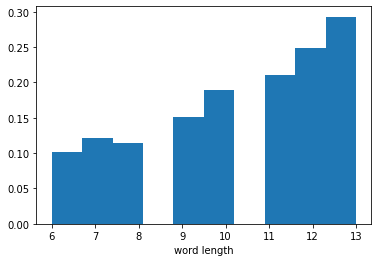

In [ ]:
plt.hist(list(map(len, labels)), bins=10, density=True)
plt.xlabel('word length');

In [ ]:
images = np.array([dataset.sample(t) for t in tqdm(labels)])

100%|██████████| 200000/200000 [23:41<00:00, 140.68it/s]


(16, 160)


Text(0.5, 0, 'ИЬОААЗКТ')

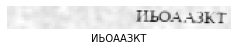

In [ ]:
show(255-images[-1])
plt.xlabel(labels[-1])

In [ ]:
np.savez_compressed('words-dataset-200k-6char', labels=labels, data=images)

In [ ]:
images.size

256000000

In [ ]:
!cp words-dataset-200k-6char.npz drive/MyDrive/ml-data/ocr-dataset

In [ ]:
!ls -lah drive/MyDrive/ml-data/ocr-dataset

total 406M
drwx------ 2 root root 4.0K Dec  3 10:06 .ipynb_checkpoints
-rw------- 1 root root  14M Dec  3 15:28 model_char0.zip
-rw------- 1 root root  14M Dec  3 15:47 model_char1.zip
-rw------- 1 root root  14M Dec  3 15:56 model_char2.zip
-rw------- 1 root root  14M Dec  3 16:41 model_char3.zip
-rw------- 1 root root  14M Dec  3 16:57 model_char4.zip
-rw------- 1 root root  15M Dec  3 18:58 model_text_len.zip
-rw------- 1 root root 103M Dec  3 10:49 words-dataset-100k.npz
-rw------- 1 root root 224M Dec  3 21:27 words-dataset-200k-6char.npz
